Waste Classifier

Import the required libraries

In [54]:
import os
import glob
import shutil
import time
import random
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report, roc_auc_score,
    roc_curve, balanced_accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score
)
from sklearn.utils.class_weight import compute_class_weight
import keras
from keras.optimizers import RMSprop, Adam, SGD
from keras import models, layers
from keras.utils import plot_model
from keras.preprocessing.image import load_img
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,
    MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D,
    Convolution2D, LSTM, SimpleRNN, GRU, Bidirectional, Permute, TimeDistributed
)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
import zipfile

Download and unzip the dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mostafaabla/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0


In [ ]:
zip_ref = zipfile.ZipFile('/content/garbage-classification.zip')
zip_ref.extractall('/content')
zip_ref.close()

Data preparation and file organization

In [ ]:
dataPath = '/content/garbage_classification'

In [ ]:
category_mapping = {
    "battery": "non-recyclable",
    "biological": "biodegradable",
    "trash": "non-recyclable",
    "brown-glass": "reusable",
    "green-glass": "reusable",
    "white-glass": "reusable",
    "cardboard": "recyclable",
    "paper": "recyclable",
    "clothes": "reusable",
    "shoes": "reusable",
    "metal": "recyclable",
    "plastic": "recyclable"
}

In [ ]:
new_dataPath = os.path.join(os.path.dirname(dataPath), "garbage-classification-merged")
os.makedirs(new_dataPath, exist_ok=True)

for new_category in set(category_mapping.values()):
    new_category_path = os.path.join(new_dataPath, new_category)
    os.makedirs(new_category_path, exist_ok=True)

file_counters = {key: 1 for key in category_mapping.values()}

clothes_path = os.path.join(dataPath, "clothes")
if os.path.exists(clothes_path):
    clothes_files = os.listdir(clothes_path)
    if len(clothes_files) > 2000:
        clothes_files = random.sample(clothes_files, 2000)

for old_category, new_category in category_mapping.items():
    old_category_path = os.path.join(dataPath, old_category)
    new_category_path = os.path.join(new_dataPath, new_category)

    if os.path.exists(old_category_path):
        file_list = os.listdir(old_category_path)
        if old_category == "clothes":
            file_list = clothes_files

        for file_name in file_list:
            old_file_path = os.path.join(old_category_path, file_name)

            if os.path.isfile(old_file_path):
                new_file_name = f"{new_category}{file_counters[new_category]}.jpg"
                file_counters[new_category] += 1

                new_file_path = os.path.join(new_category_path, new_file_name)
                shutil.copy2(old_file_path, new_file_path)

        print(f"All files from '{old_category}' have been copied to '{new_category}'.")

print("Copying and renaming completed.")

All files from 'battery' have been copied to 'non-recyclable'.
All files from 'biological' have been copied to 'biodegradable'.
All files from 'trash' have been copied to 'non-recyclable'.
All files from 'brown-glass' have been copied to 'reusable'.
All files from 'green-glass' have been copied to 'reusable'.
All files from 'white-glass' have been copied to 'reusable'.
All files from 'cardboard' have been copied to 'recyclable'.
All files from 'paper' have been copied to 'recyclable'.
All files from 'clothes' have been copied to 'reusable'.
All files from 'shoes' have been copied to 'reusable'.
All files from 'metal' have been copied to 'recyclable'.
All files from 'plastic' have been copied to 'recyclable'.
Copying and renaming completed.


In [ ]:
count_all_data = []
for subdir in os.listdir(new_dataPath):
    subdir_path = os.path.join(new_dataPath, subdir)

    if os.path.isdir(subdir_path):
        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        num_images = len(image_files)
        count_all_data.append(num_images)
        print(f"{subdir}: {num_images}")

print(f"Total: {sum(count_all_data)}")

non-recyclable: 1642
biodegradable: 985
recyclable: 3575
reusable: 5988
Total: 12190


In [ ]:
classes = os.listdir(new_dataPath)
class_indices = {name: index for index, name in enumerate(classes)}
class_indices

{'non-recyclable': 0, 'biodegradable': 1, 'recyclable': 2, 'reusable': 3}

Dataset splitting, moving and duplicate check

In [ ]:
train_dir = "content/Dataset/train"
val_dir = "content/Dataset/val"
test_dir = "content/Dataset/test"

BATCH_SIZE = 64
TARGET_SIZE = (299, 299)

In [50]:
for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)
    for cls in classes:
        os.makedirs(os.path.join(directory, cls), exist_ok=True)

random.seed(42)

def safe_train_test_split(images, test_size, stratify_labels=None):
    if stratify_labels is not None and len(set(stratify_labels)) > 1:
        return train_test_split(images, test_size=test_size, stratify=stratify_labels, random_state=42)
    else:
        return train_test_split(images, test_size=test_size, random_state=42, shuffle=True)

def move_images(image_list, source, destination):
    if len(os.listdir(destination)) == 0:
        for image in image_list:
            shutil.copy(os.path.join(source, image), os.path.join(destination, image))
        print(f"Moved {len(image_list)} images to '{destination}'.")
    else:
        print(f"Data already exists in '{destination}', skipping move.")

for cls in classes:
    class_path = os.path.join(new_dataPath, cls)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        if len(images) < 2:
            print(f"Skipping '{cls}' because only {len(images)} image(s) found (minimum 2 needed for stratification).")
            continue

        labels = [cls] * len(images)

        train_images, temp_images = safe_train_test_split(images, test_size=0.10, stratify_labels=labels)
        val_images, test_images = safe_train_test_split(temp_images, test_size=0.30, stratify_labels=[cls] * len(temp_images))

        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        move_images(train_images, class_path, os.path.join(train_dir, cls))
        move_images(val_images, class_path, os.path.join(val_dir, cls))
        move_images(test_images, class_path, os.path.join(test_dir, cls))

        print("-" * 60)

print("Dataset splitting completed.")

Data already exists in 'content/Dataset/train/non-recyclable', skipping move.
Data already exists in 'content/Dataset/val/non-recyclable', skipping move.
Data already exists in 'content/Dataset/test/non-recyclable', skipping move.
------------------------------------------------------------
Data already exists in 'content/Dataset/train/biodegradable', skipping move.
Data already exists in 'content/Dataset/val/biodegradable', skipping move.
Data already exists in 'content/Dataset/test/biodegradable', skipping move.
------------------------------------------------------------
Data already exists in 'content/Dataset/train/recyclable', skipping move.
Data already exists in 'content/Dataset/val/recyclable', skipping move.
Data already exists in 'content/Dataset/test/recyclable', skipping move.
------------------------------------------------------------
Data already exists in 'content/Dataset/train/reusable', skipping move.
Data already exists in 'content/Dataset/val/reusable', skipping mov

In [51]:
train_images = set()
val_images = set()
test_images = set()

for cls in os.listdir(train_dir):
    train_images.update(os.listdir(os.path.join(train_dir, cls)))

for cls in os.listdir(val_dir):
    val_images.update(os.listdir(os.path.join(val_dir, cls)))

for cls in os.listdir(test_dir):
    test_images.update(os.listdir(os.path.join(test_dir, cls)))

overlap = (train_images & val_images) | (train_images & test_images) | (val_images & test_images)

if overlap:
    print(f"Duplicate images found: {overlap}")
else:
    print("No duplicate images found between train, validation, and test sets.")

No duplicate images found between train, validation, and test sets.


In [ ]:
def count_images_in_subfolders(directory):
    total_images = 0
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            total_images += len(os.listdir(subdir_path))
    return total_images

train_samples = count_images_in_subfolders(train_dir)
validation_samples = count_images_in_subfolders(val_dir)
test_samples = count_images_in_subfolders(test_dir)

print(f"Train samples: {train_samples}")
print(f"Validation samples: {validation_samples}")
print(f"Test samples: {test_samples}\n")

print(f"Total images: {train_samples + validation_samples + test_samples}")
print(f"Total classes: {len(classes)}")

Train samples: 10969
Validation samples: 853
Test samples: 368

Total images: 12190
Total classes: 4


Image data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 10969 images belonging to 4 classes.
Found 853 images belonging to 4 classes.
Found 368 images belonging to 4 classes.


Class weights computation

In [ ]:
class_names = train_generator.class_indices
class_names_list = list(class_names.keys())
class_indices = {name: index for index, name in enumerate(class_names_list)}

In [ ]:
def compute_class_weights(train_path):
    files = [i for i in glob.glob(train_path + "//*//*")]
    labels = [os.path.dirname(i).split("/")[-1] for i in files]
    class_labels = sorted(set(labels))
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array(class_labels), y=labels)
    return dict(zip(class_labels, class_weights))

class_weight_dict = compute_class_weights(train_dir)
display(class_weight_dict)

{'biodegradable': np.float64(3.0950902934537248),
 'non-recyclable': np.float64(1.8566350710900474),
 'recyclable': np.float64(0.8524246192104445),
 'reusable': np.float64(0.5088606420486176)}

Model architecture

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        accuracy = logs.get('accuracy')

        if val_accuracy is not None and accuracy is not None:
            if val_accuracy > 0.97 and accuracy > 0.97:
                print("\nAccuracy and validation accuracy are above 97%, stopping training.")
                self.model.stop_training = True
            else:
                print("\nAccuracy not yet above 97%, continuing training.")
        else:
            print("\nAccuracy values not available. Continuing training.")

callbacks = myCallback()

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=2, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=2, min_lr=1e-6),
    callbacks
]

In [52]:
tf.config.optimizer.set_jit(False)

base_model = tf.keras.applications.Xception(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential()
model.add(base_model)

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax'))

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 512)    │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,857,388 (140.60 MB)

 Trainable params: 15,994,884 (61.02 MB)

 Non-trainable params: 20,862,504 (79.58 MB)

Model training

In [ ]:
history = model.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    class_weight=class_weight_dict
)

Epoch 1/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9010 - loss: 0.3077
Accuracy not yet above 97%, continuing training.
172/172 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9010 - loss: 0.3075 - val_accuracy: 0.9437 - val_loss: 0.1733 - learning_rate: 0.0010
Epoch 2/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9384 - loss: 0.1768
Accuracy not yet above 97%, continuing training.
172/172 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.9384 - loss: 0.1768 - val_accuracy: 0.9496 - val_loss: 0.2103 - learning_rate: 0.0010
Epoch 3/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9446 - loss: 0.1772
Accuracy not yet above 97%, continuing training.
172/172 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.9446 - loss: 0.1771 - val_accuracy: 0.9578 - val_loss: 0.1646 - learning_rate: 0.0010
Epoch 4/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9565 - loss: 0.1494
Accuracy not yet above 97%, continuing training.
172/172 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/s

Save the model

In [ ]:
model.save('garbage_classification_model.keras')

In [ ]:
model = tf.keras.models.load_model('/content/garbage_classification_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = '/content/garbage_classification_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved at {tflite_model_path}")

Saved artifact at '/tmp/tmpdz75ahx4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137172301306704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137172301306896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137172804748496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137172301315152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137172301314960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137172804751568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137172804749072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137172804753488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137172804752720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137172804749648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1371728047557

Model evaluation

In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Model Accuracy: {accuracy:.4f}\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step
Model Accuracy: 0.3505

                precision    recall  f1-score   support

 biodegradable       0.03      0.03      0.03        30
non-recyclable       0.10      0.10      0.10        50
    recyclable       0.32      0.32      0.32       108
      reusable       0.49      0.49      0.49       180

      accuracy                           0.35       368
     macro avg       0.24      0.24      0.24       368
  weighted avg       0.35      0.35      0.35       368



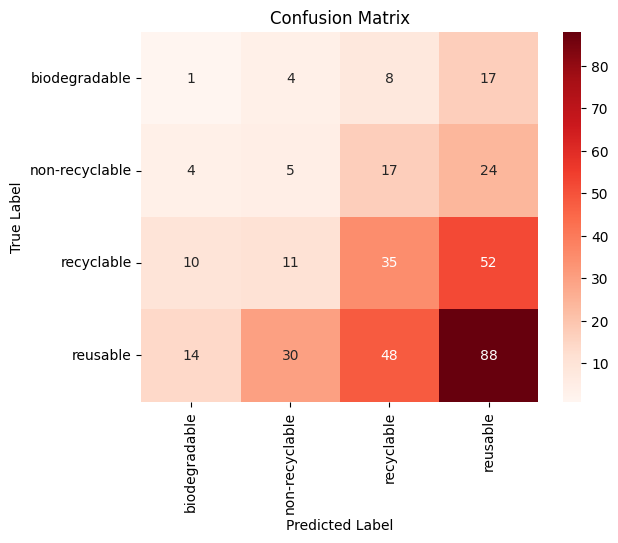

In [62]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_labels = list(test_generator.class_indices.keys())
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Visualizing accuracy and loss over epochs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

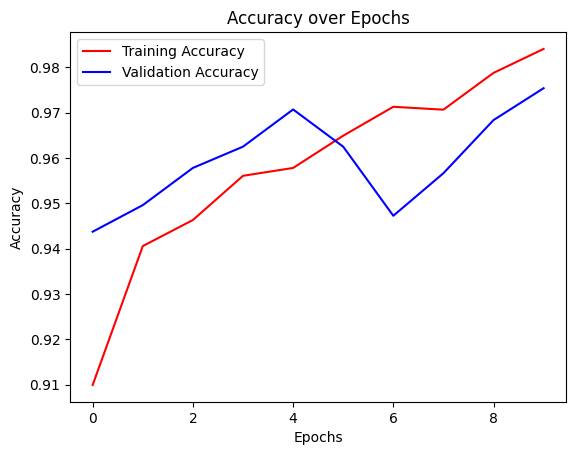

In [ ]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

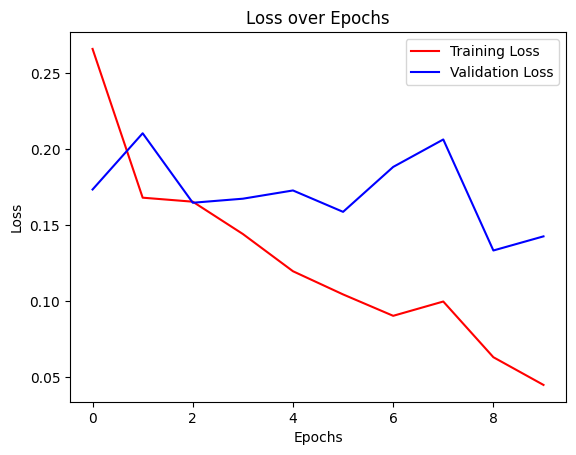

In [ ]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Model prediction

In [ ]:
model = tf.keras.models.load_model('/content/garbage_classification_model.keras')

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    class_labels = ['biodegradable', 'non-recyclable', 'recyclable', 'reusable']

    predicted_label = class_labels[predicted_class[0]]


    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
The predicted class for the image is: biodegradable


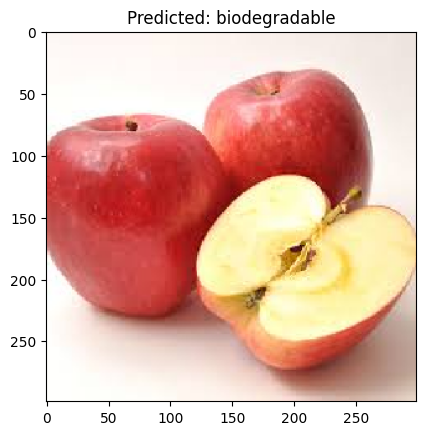

In [55]:
image_path = '/content/garbage-classification-merged/biodegradable/biodegradable1.jpg'
predict_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
The predicted class for the image is: non-recyclable


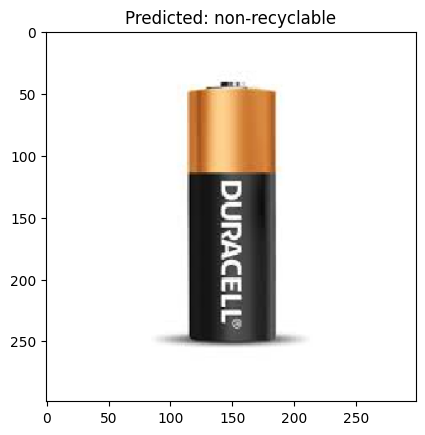

In [56]:
image_path = '/content/garbage-classification-merged/non-recyclable/non-recyclable1.jpg'
predict_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
The predicted class for the image is: recyclable


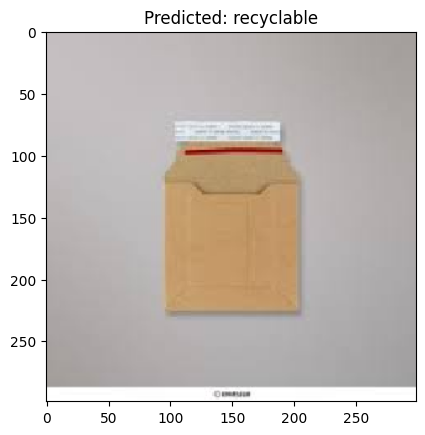

In [57]:
image_path = '/content/garbage-classification-merged/recyclable/recyclable1.jpg'
predict_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
The predicted class for the image is: reusable


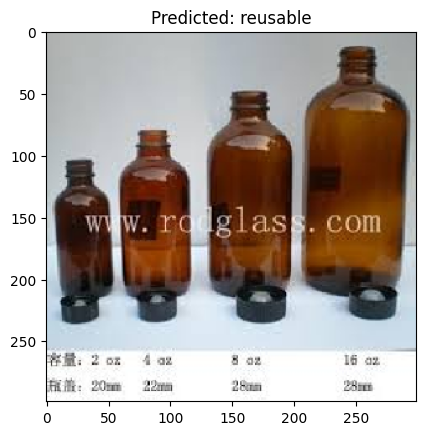

In [58]:
image_path = '/content/garbage-classification-merged/reusable/reusable1.jpg'
predict_image(image_path)